### Imports

In [35]:
import pandas as pd 
import re
import numpy as np 
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict
from io import BytesIO
from PIL import Image
from scipy.spatial import KDTree
# to get OSM way geometries
import requests 

### Data

In [2]:
tdf = pd.read_csv('data/train-1500.csv')
mdf = pd.read_csv('data/matched_results_1500_updated.csv')
osm_edges = pd.read_csv('data/edges.csv')

### Code w/o `requests`

In [104]:
def linestring_2_locations(x):
    x = re.findall('-?\d+[.]\d+', x)
    if len(x) == 0:
        return np.zeros((0,2))
    x = list(map(float, x))
    x = np.array(x).reshape((-1,2))
    return x

def s2l(x, type):
    if type == int:
        x = re.findall('\d+', x)
    else:
        x = re.findall('-?\d+[.]\d+', x)
    x = list(map(type, x))
    x = np.array(x)
    return x

def to_int(x):
    return s2l(x, int)

def to_float(x):
    return s2l(x, float)

def bbox_overlap(box1, box2):
    min_x1, min_y1, max_x1, max_y1 = box1
    min_x2, min_y2, max_x2, max_y2 = box2    
    horizontal_overlap = min_x1 < max_x2 and max_x1 > min_x2
    vertical_overlap = min_y1 < max_y2 and max_y1 > min_y2    
    overlap = horizontal_overlap and vertical_overlap
    return overlap

def merge_bounding_boxes(box1, box2):
    min_x1, min_y1, max_x1, max_y1 = box1
    min_x2, min_y2, max_x2, max_y2 = box2
    return np.min([min_x1,min_x2]), np.min([min_y1, min_y2]), np.max([max_x1, max_x2]), np.max([max_y1, max_y2])  

### get network edges
def get_intersecting_edges(osm_edges, bounding_box):
    edges = []
    for _, row in osm_edges.iterrows():
        edge_trajectory = linestring_2_locations(row.geometry)
        lon, lat = edge_trajectory.T        
        if bbox_overlap((np.min(lon), np.min(lat), np.max(lon), np.max(lat)), bounding_box):
            edges.append([lon, lat])
    return edges

def plot_network(osm_edges, bounding_box, ax, label=None):
    edges = get_intersecting_edges(osm_edges, bounding_box)
    parts = []
    first = True
    for lons, lats in edges:
        temp = ax.plot(lons, lats, '-',c='k', linewidth=.5, label=label if first else None)
        first = False
        parts.extend(temp)
    return parts

def plot_trajectory(lon, lat, ax, color='red'):
    return ax.plot(lon, lat, '-', c=color, linewidth=2, alpha=1, solid_capstyle='round')


def lat_lon_padding(min_lon, min_lat, max_lon, max_lat, padding):
    avg_lat = np.radians((min_lat + max_lat) / 2)
    
    # Latitude padding (constant)
    lat_padding = padding / 111320.0    
    # Longitude padding (scales with cosine of latitude)
    lon_padding = padding / (111320.0 * np.cos(avg_lat))
    
    # Apply padding
    new_min_lat = min_lat - lat_padding
    new_max_lat = max_lat + lat_padding
    new_min_lon = min_lon - lon_padding
    new_max_lon = max_lon + lon_padding
    
    return new_min_lon, new_min_lat, new_max_lon, new_max_lat

def get_padded_bounding_box(lons, lats, padding):
    return lat_lon_padding(np.min(lons), np.min(lats), np.max(lons), np.max(lats), padding)


def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = np.radians(lat_deg)
    n = 1 << zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - np.arcsinh(np.tan(lat_rad)) / np.pi) / 2.0 * n)
    return xtile, ytile

def get_tile_range(bbox, zoom):
    min_lon, min_lat, max_lon, max_lat = bbox
    x1, y1 = deg2num(min_lat, min_lon, zoom)
    x2, y2 = deg2num(max_lat, max_lon, zoom)
    min_x = np.min([x1,x2])
    min_y = np.min([y1,y2])
    max_x = np.max([x1,x2])
    max_y = np.max([y1,y2])
    return min_x, min_y, max_x, max_y

def tile_to_bbox(x_tile, y_tile, zoom):
    # Number of tiles at this zoom level
    n = 2 ** zoom
    
    # Longitude bounds
    lon_left = x_tile / n * 360.0 - 180.0
    lon_right = (x_tile + 1) / n * 360.0 - 180.0
    
    # Latitude bounds
    lat_top = np.degrees(np.arctan(np.sinh(np.pi * (1 - 2 * y_tile / n))))
    lat_bottom = np.degrees(np.arctan(np.sinh(np.pi * (1 - 2 * (y_tile + 1) / n))))
    
    return lon_left, lat_bottom, lon_right, lat_top


def haversine(lon1, lat1, lon2, lat2, radius=6371):
    """
    Calculate the great-circle distance between two points using the Haversine formula.

    Args:
    - lat1, lon1: Latitude and longitude of the first point (in degrees).
    - lat2, lon2: Latitude and longitude of the second point (in degrees).
    - radius: Radius of the Earth (default: 6371 km).

    Returns:
    - distance: Great-circle distance between the points (in the same units as the radius).
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance
    distance = radius * c
    return distance



def lon_lat_to_xy(lon, lat, radius=6378137.0):
    """
    Convert latitude and longitude to x, y coordinates using the Mercator projection.

    Args:
    - lat: Latitude in degrees (can be a scalar or NumPy array).
    - lon: Longitude in degrees (can be a scalar or NumPy array).
    - radius: Earth's radius in meters (default: 6378137.0, WGS84 ellipsoid).

    Returns:
    - x: X coordinate in meters.
    - y: Y coordinate in meters.
    """
    # Convert lat and lon from degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Apply Mercator projection formulas
    x = radius * lon_rad
    y = radius * np.log(np.tan(np.pi / 4 + lat_rad / 2))
    
    return x, y

In [185]:
all_ways = get_all_ways()

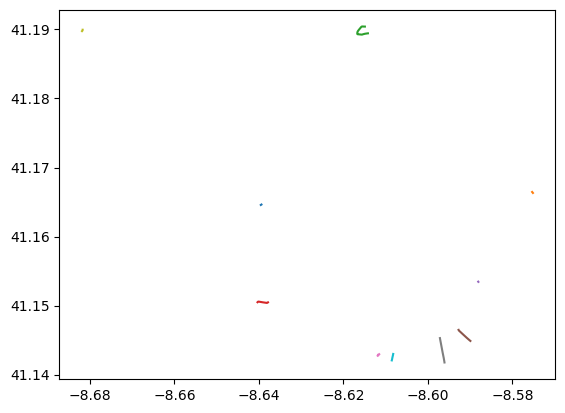

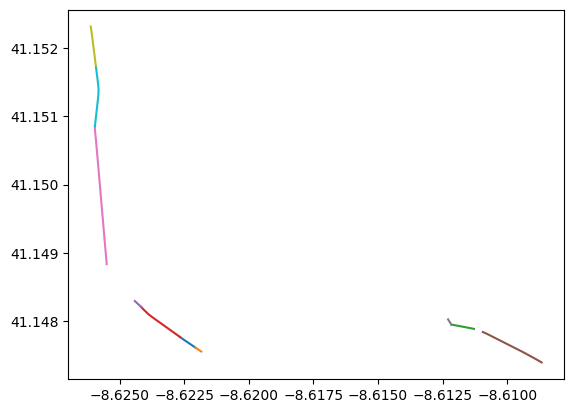

In [280]:
for entry,ax in zip(top_k_avg_time, axs):
    wid, time = entry
    g = traj_df.loc[traj_df.wid == wid]
    plt.plot(g.lon, g.lat, label=f'{wid}')
# plt.legend()
plt.show()

for entry,ax in zip(top_k_trips, axs):
    wid, trip_count = entry
    g = traj_df.loc[traj_df.wid == wid]
    plt.plot(g.lon, g.lat, label=f'{wid}')
# plt.legend()
plt.show()


### Code using `requests`

In [5]:
TILE_CACHE = {}
WAY_CACHE = {}

In [288]:
OVERPASS_URL = "http://overpass-api.de/api/interpreter"

def get_all_ways():    
    query = f'''
    [out:json];
    area["name"="Porto"];
    way(area);
    out geom;
    '''
    response = requests.post(OVERPASS_URL, data={"data": query})
    data = response.json()
    ways = data['elements']
    return ways

def get_ways(way_ids):
    required = []
    for wid in way_ids:
        if wid in WAY_CACHE:
            continue
        required.append(wid)

    if len(required) > 0:
        query = "[out:json];"
        for wid in required:
            query += f" way({wid}); out geom;"
    
        response = requests.post(OVERPASS_URL, data={"data": query})
        data = response.json()
        
        for way in data['elements']:
            WAY_CACHE[way['id']] = way

    ways = []
    for wid in way_ids:
        if wid in WAY_CACHE:
            way = WAY_CACHE[wid]
            ways.append(way)

    return ways

def get_way(way_id):
    if way_id in WAY_CACHE:
        return WAY_CACHE[way_id]
    
    query = f'''
    [out:json];
    way({way_id});
    out geom;
    '''
    response = requests.post(OVERPASS_URL, data={"data": query})
    data = response.json()
    way = data['elements'][0]
    WAY_CACHE[way_id] = way
    
    return way

In [7]:
def get_tile(z,x,y):
    tk = (z,x,y)
    if tk in TILE_CACHE:
        return TILE_CACHE[tk]
    
    url = f'https://tile.openstreetmap.org/{z}/{x}/{y}.png'

    headers = {
        'User-Agent': f"AI6128_project/1.0 (fung0024@e.ntu.edu.sg)"
    }
    
    response = requests.get(url, headers=headers)    
    img = Image.open(BytesIO(response.content))
    img = np.array(img.convert('RGB'))
    
    TILE_CACHE[tk] = img
    return img

### Visualize match
- converts lon & lat to x & y to that units are in meters
- finds bounding boxes for trajectories
- merges the bounding boxes
- get road network edges intersecting merged bounding box
- plot road network edges
- plot trajectories
- crop to bounding box

In [299]:
def get_stitched_tiles(bbox, zoom):
    min_x, min_y, max_x, max_y = get_tile_range(bbox, zoom)
    tbbox1 = tile_to_bbox(min_x, min_y, zoom)
    tbbox2 = tile_to_bbox(max_x, max_y, zoom)
    min_lon, min_lat, max_lon, max_lat = merge_bounding_boxes(tbbox1, tbbox2)
    extent = [min_lon, max_lon, min_lat, max_lat]

    stitched = []
    for y in range(min_y, max_y+1):
        cols = []
        for x in range(min_x, max_x+1):
            tile = get_tile(zoom, x, y)
            cols.append(tile)
        row = np.hstack(cols)
        stitched.append(row)
    stitched = np.vstack(stitched)
    
    return stitched, extent

12266 12268 15598 15599


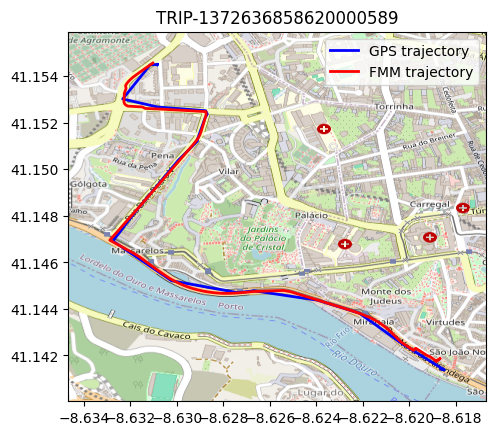

In [53]:
_, ax = plt.subplots(1,1)
bbox_padding = 150 # in meters
idx = 0

# convert string to trajectory
tid = tdf.TRIP_ID.iloc[idx]
gps_path = linestring_2_locations(tdf.POLYLINE.iloc[idx])
match_pts = linestring_2_locations(mdf.match_pt.iloc[idx])
match_geom = linestring_2_locations(mdf.match_geom.iloc[idx])

# get x,y from gps trajectory
lon1, lat1 = gps_path.T
bbox1 = get_padded_bounding_box(lon1, lat1, bbox_padding)

# get x,y from fmm path
lon2, lat2 = match_geom.T
bbox2 = get_padded_bounding_box(lon2, lat2, bbox_padding)

# combine bounding boxes
bbox = merge_bounding_boxes(bbox1, bbox2)

# # plot edges intersecting bounding box
# t0 = plot_network(osm_edges, bbox, ax, label='road')[0]

zoom = 15
min_x, min_y, max_x, max_y = get_tile_range(bbox, zoom)
tbbox1 = tile_to_bbox(min_x, min_y, zoom)
tbbox2 = tile_to_bbox(max_x, max_y, zoom)
min_lon, min_lat, max_lon, max_lat = merge_bounding_boxes(tbbox1, tbbox2)
extent = [min_lon, max_lon, min_lat, max_lat]
stitched = []

print(min_y, max_y, min_x, max_x)
for y in range(min_y, max_y+1):
    cols = []
    for x in range(min_x, max_x+1):
        tile = get_tile(zoom, x, y)
        # plt.imshow(tile)
        # plt.show()
        cols.append(tile)
    row = np.hstack(cols)
    stitched.append(row)
stitched = np.vstack(stitched)
plt.imshow(stitched, extent=extent)
# plt.show()

# plot trajectories for gps
t1, = ax.plot(lon1, lat1, c='blue', linewidth=2, label='GPS trajectory')

# plot trajectories for match
t2, = ax.plot(lon2, lat2, c='red', linewidth=2, label='FMM trajectory')

# crop to bounding box
lon_min, lat_min, lon_max, lat_max = bbox
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])

ax.legend()
ax.set_title('TRIP-'+str(tid))
plt.show()

In [ ]:
_, ax = plt.subplots(1,1)
bbox_padding = 150 # in meters
idx = 0

# convert string to trajectory
tid = tdf.TRIP_ID.iloc[idx]
gps_path = linestring_2_locations(tdf.POLYLINE.iloc[idx])
match_pts = linestring_2_locations(mdf.match_pt.iloc[idx])
match_geom = linestring_2_locations(mdf.match_geom.iloc[idx])

### Analysis

In [94]:
number_of_trips = defaultdict(lambda: 0)
for _, row in mdf.iterrows():
    eids = to_int(row.match_path)
    match_eids = to_int(row.match_edge_by_idx)
    trip_wids = []
    for i in range(len(match_eids)-1):
        a = match_eids[i]
        b = match_eids[i+1]
        wids = to_int(str(osm_edges.iloc[eids[a:b+1]].osmid.values))
        trip_wids.extend(wids)
    trip_wids = set(trip_wids)
    for wid in trip_wids:
        number_of_trips[wid] += 1

4256491
108390772
479127839


In [282]:
all_eids_in_matches = []
for path in mdf.match_path:
    all_eids_in_matches.extend(to_int(path))
all_eids_in_matches = list(set(all_eids_in_matches))

all_wids_in_matches = []
for eid in all_eids_in_matches:
    all_wids_in_matches.extend(to_int(osm_edges.iloc[eid].osmid))
all_wids_in_matches = list(set(all_wids_in_matches))

In [289]:
all_ways_in_matches = get_ways(all_wids_in_matches)

In [295]:
length_of_wids = defaultdict(lambda: 0)
wid_to_way = {}
for way in all_ways_in_matches:
    g = pd.DataFrame(way['geometry'])    
    dx = np.diff(g.lon)
    dy = np.diff(g.lat)
    segment_lengths = np.sqrt(dx**2 + dy**2)
    trajectory_length = np.sum(segment_lengths)
    length_of_wids[way['id']] = trajectory_length
    wid_to_way[way['id']] = way

In [293]:
time_spent = defaultdict(lambda: 0)

for _, row in mdf.iterrows():
    eids = to_int(row.match_path)
    match_eids = to_int(row.match_edge_by_idx)
    for i in range(len(match_eids)-1):
        a = match_eids[i]
        b = match_eids[i+1]
        wids = to_int(str(osm_edges.iloc[eids[a:b+1]].osmid.values))
        total_len = 0
        for wid in wids:
            l = length_of_wids[wid]
            total_len += l
        if total_len == 0:
            continue
        
        for wid in wids:
            l = wid_to_length[wid]
            time_spent[wid] += 15 * l/total_len

In [294]:
num_of_trips_list = []
avg_time_spent_list = []

for wid in number_of_trips:
    num_of_trips_list.append((wid, number_of_trips[wid]))

for wid in time_spent:
    if number_of_trips[wid] == 0:
        continue
    avg_time_spent_list.append((wid, time_spent[wid] / number_of_trips[wid]))

top_k_trips = heapq.nlargest(10, num_of_trips_list, key=lambda x: x[1])
top_k_avg_time = heapq.nlargest(10, avg_time_spent_list, key=lambda x: x[1])

### Viz top 10

#### individual trip freq

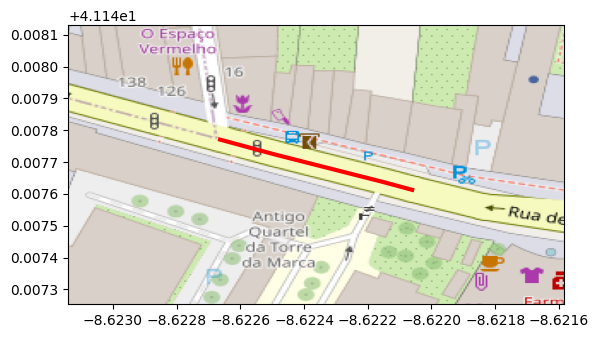

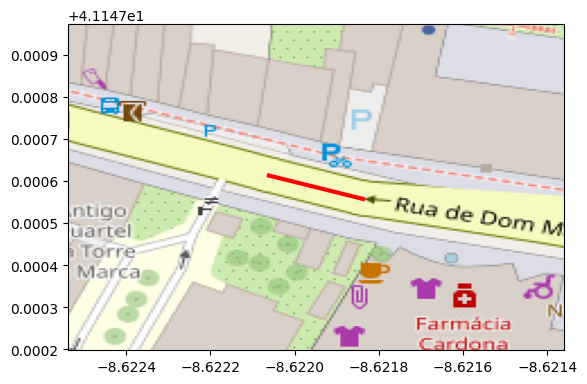

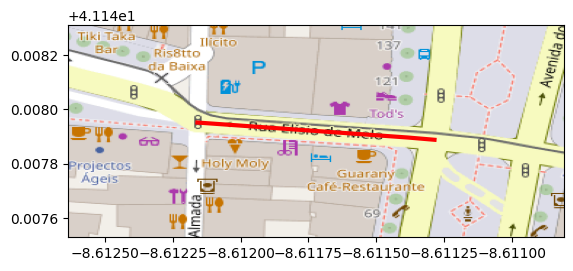

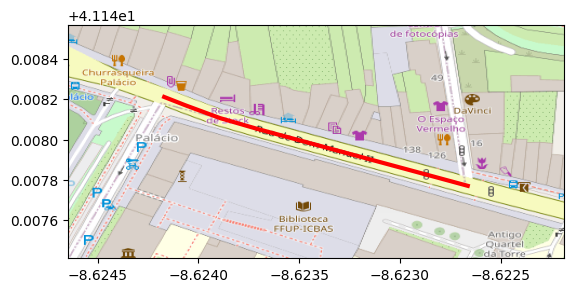

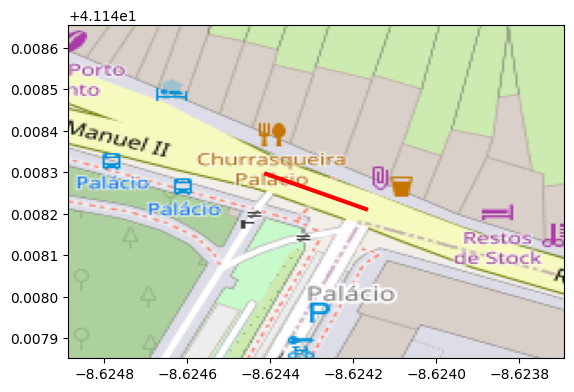

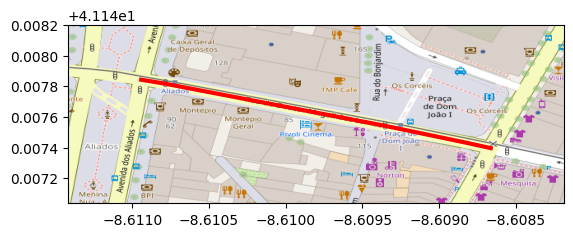

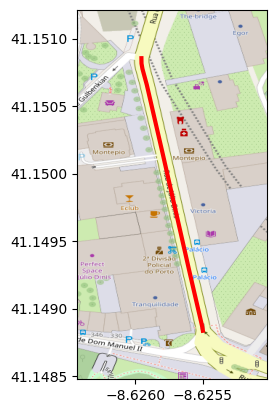

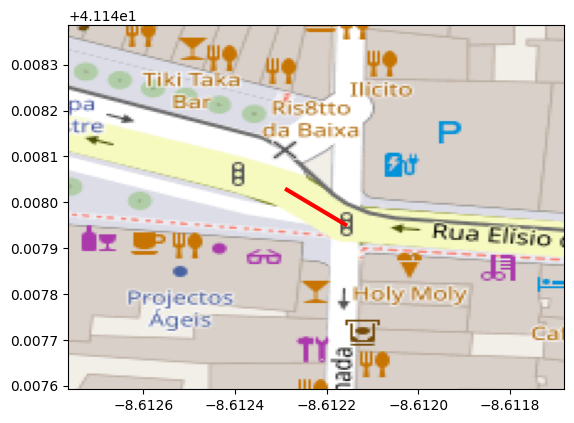

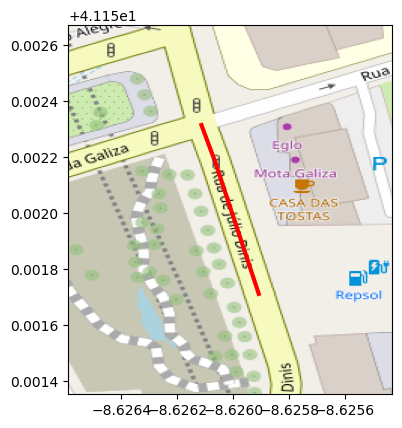

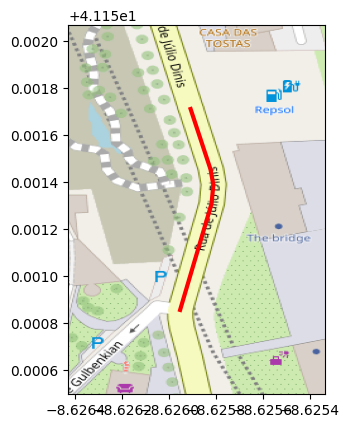

In [338]:
padding = 40
for wid, n_trips in top_k_trips:
    g = pd.DataFrame(wid_to_way[wid]['geometry'])
    bbox = get_padded_bounding_box(g.lon, g.lat, padding)
    min_lon, min_lat, max_lon, max_lat = bbox
    stitched, extent = get_stitched_tiles(bbox, 18)
    plt.imshow(stitched, extent=extent)
    plt.plot(g.lon, g.lat, '-', c='red', linewidth=3)
    min_lon, min_lat, max_lon, max_lat = bbox
    plt.xlim([min_lon, max_lon])
    plt.ylim([min_lat, max_lat])
    plt.show()

#### indiv time

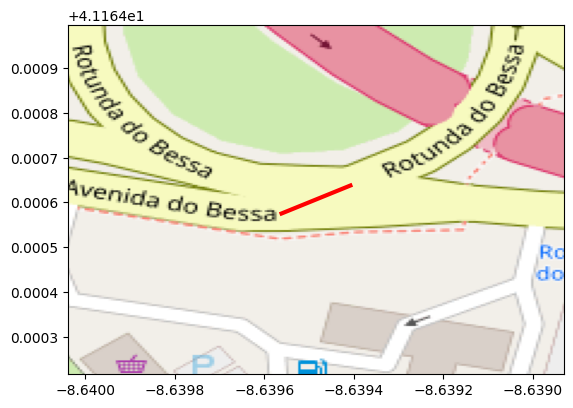

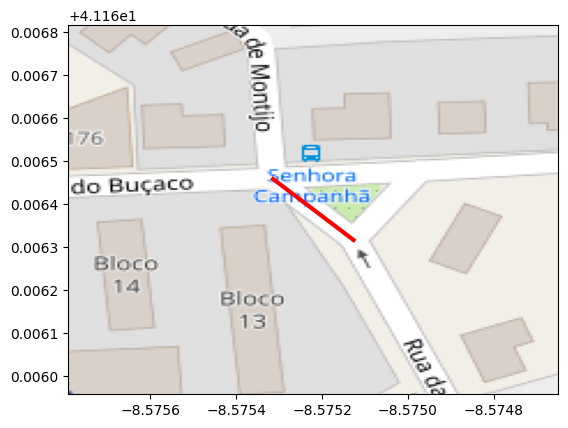

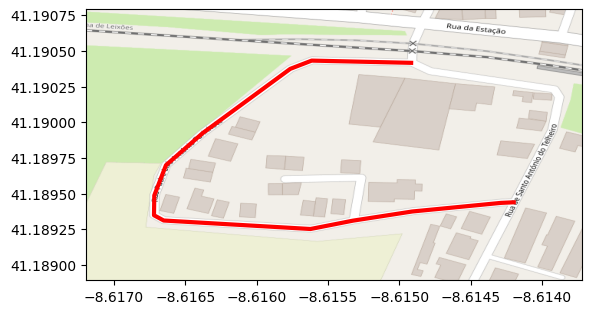

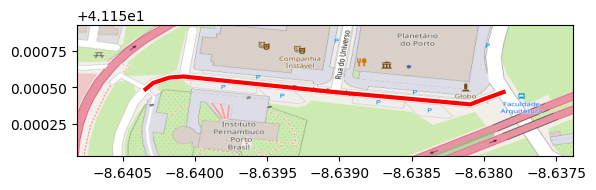

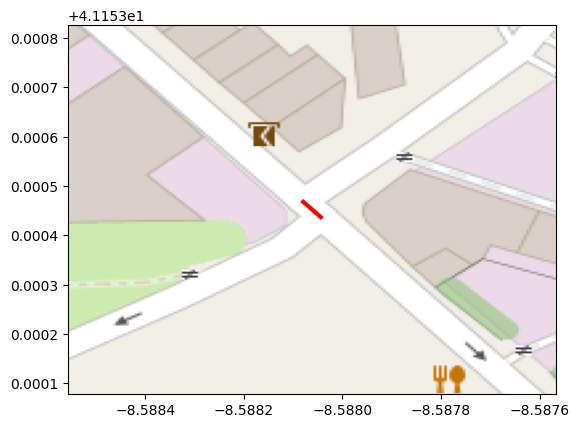

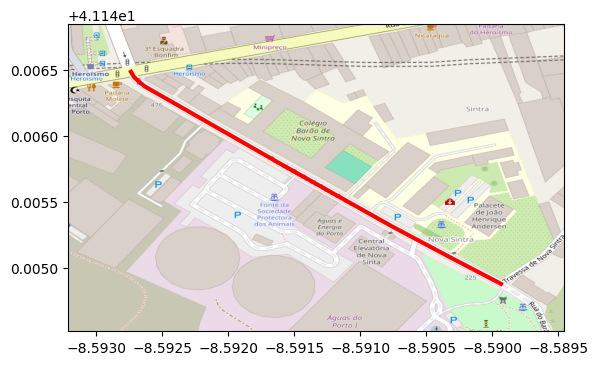

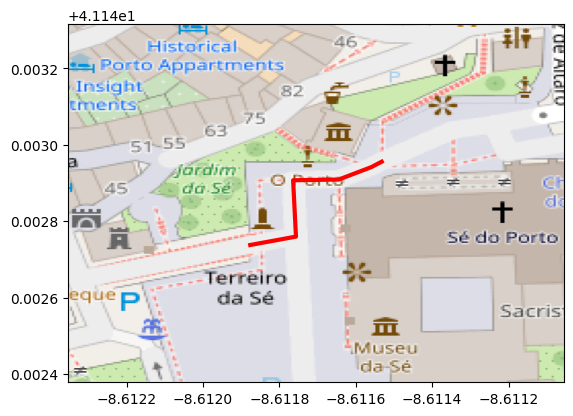

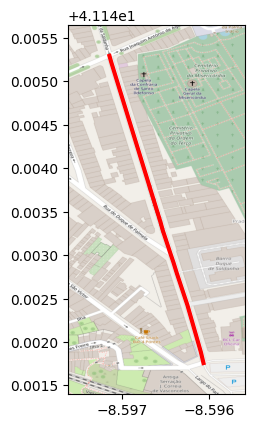

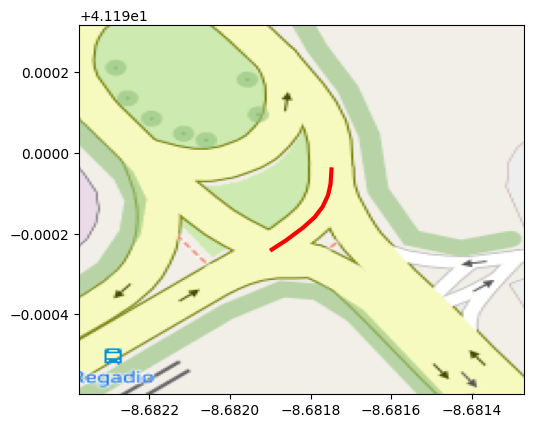

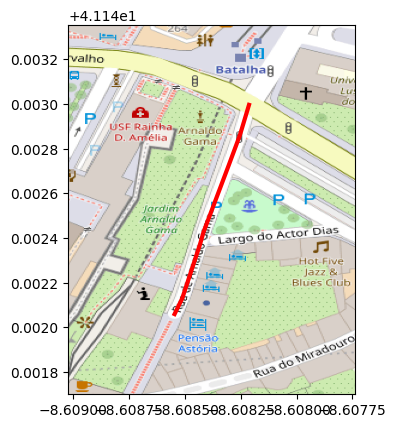

In [339]:
padding = 40
for wid, n_trips in top_k_avg_time:
    g = pd.DataFrame(wid_to_way[wid]['geometry'])
    bbox = get_padded_bounding_box(g.lon, g.lat, padding)
    min_lon, min_lat, max_lon, max_lat = bbox
    stitched, extent = get_stitched_tiles(bbox, 18)
    plt.imshow(stitched, extent=extent)
    plt.plot(g.lon, g.lat, '-', c='red', linewidth=3)
    min_lon, min_lat, max_lon, max_lat = bbox
    plt.xlim([min_lon, max_lon])
    plt.ylim([min_lat, max_lat])
    plt.show()

#### together, trip freq

Rua de Dom Manuel II                               	 434860177 	 142
Rua de Dom Manuel II                               	 1174835646 	 142
Rua Elísio de Melo                                 	 26119900 	 135
Rua de Dom Manuel II                               	 156211618 	 127
Rua de Dom Manuel II                               	 1307144120 	 127
Rua do Doutor Magalhães Lemos                      	 190128487 	 126
Rua de Júlio Dinis                                 	 36748084 	 120
Rua Elísio de Melo                                 	 1001166329 	 118
Rua de Júlio Dinis                                 	 482296560 	 118
Rua de Júlio Dinis                                 	 482296561 	 118


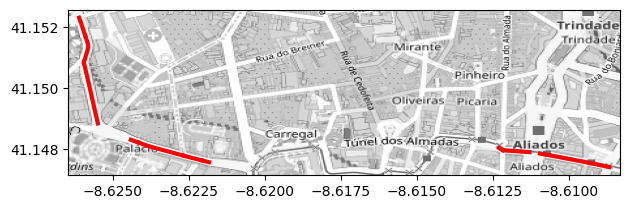

In [373]:
padding = 30
overall_bbox = None

for wid, n_trips in top_k_trips:
    g = pd.DataFrame(wid_to_way[wid]['geometry'])
    bbox = get_padded_bounding_box(g.lon, g.lat, padding)
    if overall_bbox is None:
        overall_bbox = bbox
    else:
        overall_bbox = merge_bounding_boxes(bbox, overall_bbox)
    
stitched, extent = get_stitched_tiles(overall_bbox, 15)
plt.imshow(stitched[:,:,0], extent=extent, cmap='grey')

for wid, n_trips in top_k_trips:
    way = wid_to_way[wid]
    g = pd.DataFrame(way['geometry'])
    print('%-50s \t %d \t %d' % (
        way['tags'].get('name', 'Unnamed'),
        way['id'], 
        n_trips
    ))
    plt.plot(g.lon, g.lat, '-', linewidth=3, label=f'{wid}', c='red')

a,b,c,d = overall_bbox
plt.xlim([a,c])
plt.ylim([b,d])
plt.tight_layout()

### together time

Avenida do Bessa                                   	 1232414923 	 1458.37908710 sec
Rua da Senhora de Campanhã                         	 441811501 	 736.75282279 sec
Rua Padre Luís António Farinhote                   	 36997778 	 515.29764100 sec
Rua das Estrelas                                   	 1212229103 	 483.78738851 sec
Rua de Justino Teixeira                            	 1304898903 	 411.11584607 sec
Rua do Barão de Nova Sintra                        	 432472358 	 401.41895409 sec
Terreiro da Sé                                     	 216269248 	 400.72599968 sec
Rua do Duque da Saldanha                           	 504045800 	 359.19567365 sec
Avenida O Comércio de Leixões                      	 915414408 	 330.72796283 sec
Rua de Arnaldo Gama                                	 112064480 	 292.16630733 sec


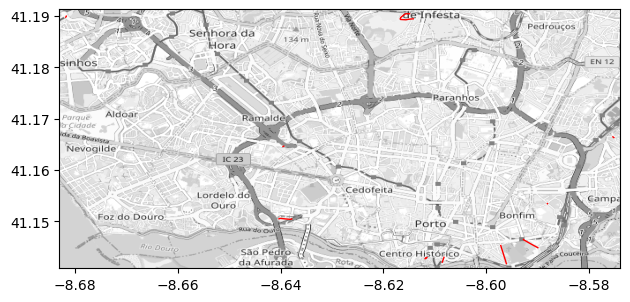

In [389]:
padding = 100
overall_bbox = None

for wid, n_trips in top_k_avg_time:
    g = pd.DataFrame(wid_to_way[wid]['geometry'])
    bbox = get_padded_bounding_box(g.lon, g.lat, padding)
    if overall_bbox is None:
        overall_bbox = bbox
    else:
        overall_bbox = merge_bounding_boxes(bbox, overall_bbox)
    
stitched, extent = get_stitched_tiles(overall_bbox, 13)
plt.imshow(stitched[:,:,1], extent=extent, cmap='grey')

for wid, time in top_k_avg_time:
    way = wid_to_way[wid]
    g = pd.DataFrame(way['geometry'])
    print('%-50s \t %d \t %.8f sec' % (
        way['tags'].get('name', 'Unnamed'),
        way['id'], 
        time
    ))
    plt.plot(g.lon, g.lat, '-', linewidth=1, label=f'{wid}', c='red')

a,b,c,d = overall_bbox
plt.xlim([a,c])
plt.ylim([b,d])
plt.tight_layout()